## Post-stack inversion with proximal solvers - Volve

Use 4 classes with slightly different centroids compared to main example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from htracker.jointinv import joint_inversion_segmentation
from htracker.workflows import *

plt.style.use('seaborn-ticks')
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

In [2]:
cmap_ai = LinearSegmentedColormap.from_list('name', ['#800000', '#ffdb4d',
                                                     '#006600', '#0099cc',
                                                     '#0059b3'])

In [3]:
def vint2vrms(vint, t):
    nt = t.size
    dt = np.diff(t)
    vrms = np.zeros(nt)
    vrms[:-1] = np.cumsum(dt * (vint[:-1]**2));
    vrms[:-1] = np.sqrt(vrms[:-1] / t[:-1]-t[0])
    vrms[-1] = vrms[-2]
    return vrms

def vrms2vint(vrms, t):
    nt = t.size
    i1 = np.arange(0, nt-1)
    i2 = np.arange(1, nt)
    vint = np.zeros(nt)
    vrms2 = vrms ** 2
    vint[i1]= np.sqrt((vrms2[i2]*(t[i2] - t[0]) - vrms2[i1]*(t[i1] - t[0])) / (t[i2] - t[i1]))

    #find and process non-physical ones
    inp = np.where(vint<0);
    if len(inp):
        vint[inp] = np.nan
    return vint

In [4]:
os.environ['NUMBA_NUM_THREADS'] = '6'

## Load data

In [5]:
f = np.load('../data/Volve2dfence_NO_15_9-19_BT2.npz',
            allow_pickle=True)

In [6]:
f.files

['t_seis',
 't_seisn',
 'z_vel',
 't_vrms',
 't_ainvt',
 'seismict_fence',
 'vel_fence',
 'vrms_fence',
 'aiinvt_fence',
 'horizons_fence',
 'well_tvdss',
 'well_twt',
 'well_ai',
 'izwellfence',
 'itwellfence',
 'xfence',
 'twell',
 'xfence_int',
 'twell_int']

In [7]:
t_seis = f['t_seis']
t_vrms = f['t_vrms']
t_ainvt = f['t_ainvt']
dt = t_seis[1] - t_seis[0]

seismic_fence = f['seismict_fence']
vrms_fence = f['vrms_fence']
aiinvt_fence = f['aiinvt_fence']
x_seis = np.arange(seismic_fence.shape[0])

horizons_fence = f['horizons_fence'][()]

well_tvdss = f['well_tvdss']
well_twt = f['well_twt']
well_ai = f['well_ai']
twell = f['twell']
twell_int = f['twell_int']
dtwell_int = twell_int[1] - twell_int[0]
xfence = f['xfence']
xfence_int = f['xfence_int']

## Compute interval velocities from RMS

Given that we have access to only RMS velocities in time, we need to estimate interval velocities from them

In [8]:
vint_fence = np.zeros_like(vrms_fence)
for ifence in range(len(x_seis)):
    vint_fence[ifence] = vrms2vint(vrms_fence[ifence], t_vrms / 1000)
vint_fence = gaussian_filter(vint_fence, sigma=30)

We now regrid the RMS velocities to the same grid as our data

In [9]:
IL, T = np.meshgrid(x_seis, t_seis, indexing='ij')

vinterp = RegularGridInterpolator((x_seis, t_vrms), vint_fence, bounds_error=False, fill_value=0)
vint_fence = vinterp(np.vstack((IL.ravel(), T.ravel())).T)
vint_fence = vint_fence.reshape(seismic_fence.shape)

## Extract traces along well trajectory

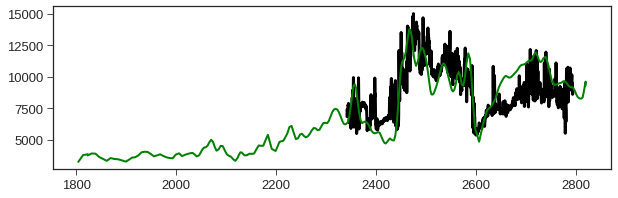

In [10]:
aiextr1_t = RegularGridInterpolator((x_seis, t_ainvt), 
                                    aiinvt_fence, 
                                    bounds_error=False, 
                                    fill_value=np.nan)(np.vstack((x_seis, twell)).T)

aiextr1_t_int = RegularGridInterpolator((xfence, t_ainvt),
                                        aiinvt_fence, 
                                        bounds_error=False,
                                        fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

nsmooth=5
plt.figure(figsize=(10, 3))
plt.plot(well_twt, 
         filtfilt(np.ones(nsmooth)/nsmooth, 1, well_ai),  
         'k', lw=3, label='AI log (t)')
plt.plot(twell_int, aiextr1_t_int, 'g', lw=2);

## Estimate wavelet

Window data and velocity model to area of interest

In [11]:
tmin, tmax = 1900, 3200
itmin, itmax = int((tmin-t_seis[0])/dt), int((tmax-t_seis[0])/dt)

vint_fence = vint_fence[:, itmin:itmax]
seismic_fence = seismic_fence[:, itmin:itmax]
t_cut = t_seis[itmin:itmax]

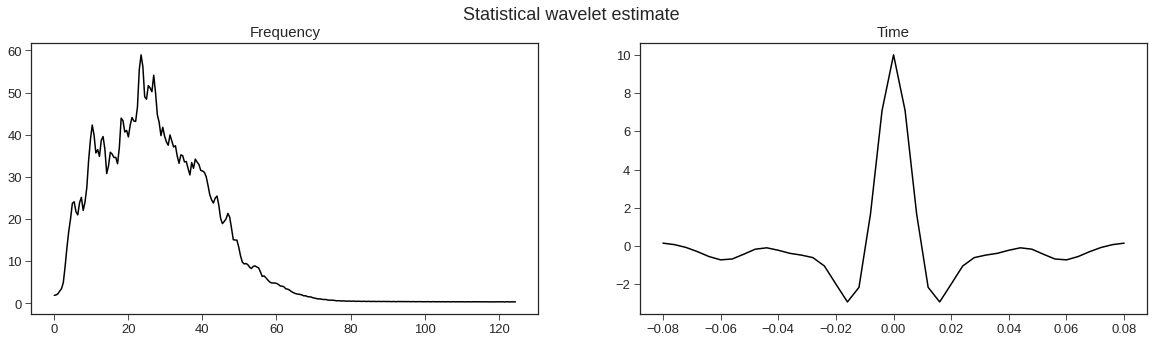

In [12]:
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT
wav_scaling = 1e1

# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(seismic_fence, nfft, axis=-1)), axis=0)
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wav_est *= wav_scaling

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

## 2D Post-stack inversion

Convert background velocities to AI

In [13]:
intercept = -3952.2622879733026
gradient = 3.3952561093488325

ai_fence = np.log(intercept + gradient*vint_fence)

ai_fence_t = RegularGridInterpolator((x_seis, t_cut), 
                                     ai_fence, 
                                     bounds_error=False, 
                                     fill_value=np.nan)(np.vstack((x_seis, twell)).T)

In [14]:
nt = itmax - itmin
nfence = x_seis.size

Lop = PoststackLinearModelling(wav_est, nt0=nt, spatdims=nfence)

In [15]:
dback = Lop * ai_fence.T.ravel()
dback = dback.reshape(nt, nfence)

In [16]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt, nfence), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], seismic_fence.T.ravel(),
                            x0=ai_fence.T.ravel(), epsRs=[2.], returninfo=False, show=True,
                            **dict(iter_lim=100, damp=1e-2))
dinv = Lop*minv

minv = minv.reshape(nt, nfence)
dback = dback.reshape(nt, nfence)
dinv = dinv.reshape(nt, nfence)

#minv_t = RegularGridInterpolator((x_seis, t_cut), 
#                                 np.exp(minv).T, 
#                                 bounds_error=False, 
#                                 fill_value=np.nan)(np.vstack((x_seis, twell)).T)

minv_t = RegularGridInterpolator((x_seis, t_cut), 
                                 np.exp(minv).T, 
                                 bounds_error=False,
                                 fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 484250 rows and 242125 columns
damp = 1.00000000000000e-02   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.702e+02  6.702e+02    1.0e+00  2.6e-02
     1  5.73684e-03   3.213e+02  3.213e+02    4.8e-01  5.2e-01   2.0e+01  1.0e+00
     2 -2.76889e-04   2.317e+02  2.317e+02    3.5e-01  3.7e-01   2.5e+01  2.2e+00
     3 -1.47647e-02   1.727e+02  1.728e+02    2.6e-01  2.4e-01   3.0e+01  3.7e+00
     4 -2.55002e-02   1.443e+02  1.443e+02    2.2e-01  1.8e-01   3.4e+01  5.2e+00
     5 -3.17088e-02   1.294e+02  1.294e+02    1.9e-01  1.3e-01   3.8e+01  6.9e+00
     6 -3.69321e-02   1.197e+02  1.197e+02    1.8e-01  1.0e-01   4.1e+01  8.7e+00
     7 -4.16456e-02   1.132e+02  1.132e+02    1.7e-01  9.2e-02   4.4e+01  1.1e+01
     8 -4.74927e-02   1.080e+0

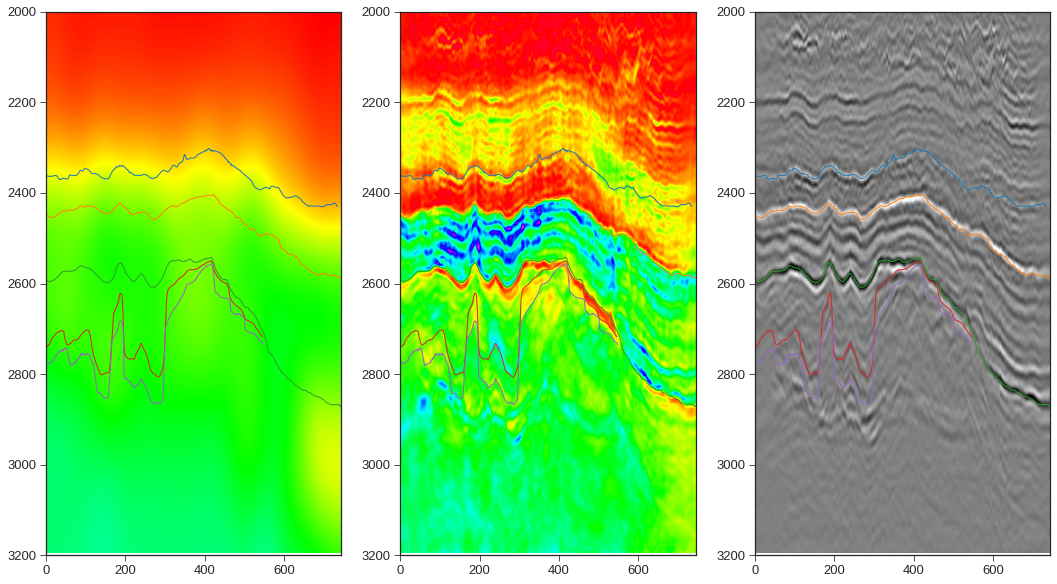

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(np.exp(ai_fence.T), cmap='gist_rainbow', vmin=3000, vmax=20000, 
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[0].plot(x_seis, horizons_fence[horname], lw=1)
axs[0].axis('tight')
axs[0].set_ylim(3200,2000);
axs[1].imshow(np.exp(minv), cmap='gist_rainbow', vmin=3000, vmax=20000, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[1].plot(x_seis, horizons_fence[horname], lw=1)
axs[1].axis('tight')
axs[1].set_ylim(3200,2000);
axs[2].imshow(seismic_fence.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[2].plot(x_seis, horizons_fence[horname], lw=1)
axs[2].axis('tight')
axs[2].set_ylim(3200,2000);

In [18]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.05
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=seismic_fence.T.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt, nfence), edge=True, dtype=Lop.dtype, kind='forward')

# steps (seems like it is unstable for too high tau)
L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.2 / np.sqrt(L)
mu = 0.95 / (tau * L)
print(tau*mu*L<1)

mpd = PrimalDual(l2, l1, Dop, ai_fence.T.ravel(), tau=tau, mu=mu, theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt, nfence)
dinv = dinv.reshape(nt, nfence)

mpd_t = RegularGridInterpolator((x_seis, t_cut), 
                                 np.exp(mpd).T, 
                                 bounds_error=False,
                                 fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

True
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 7.071068e-02	mu = 1.679379e+00
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.19730e+00   7.697e+04   8.998e+02   0.000e+00       7.786e+04
     2   8.17465e+00   8.273e+03   6.619e+02   0.000e+00       8.935e+03
     3   8.18163e+00   3.117e+03   5.997e+02   0.000e+00       3.717e+03
     4   8.18751e+00   2.337e+03   5.739e+02   0.000e+00       2.911e+03
     5   8.18927e+00   1.997e+03   5.608e+02   0.000e+00       2.558e+03
     6   8.18730e+00   1.689e+03   5.549e+02   0.000e+00       2.244e+03
     7   8.18438e+00   1.442e+03   5.539e+02   0.000e+00       1.995e+03
     8   8.18259e+00   1.252e+0

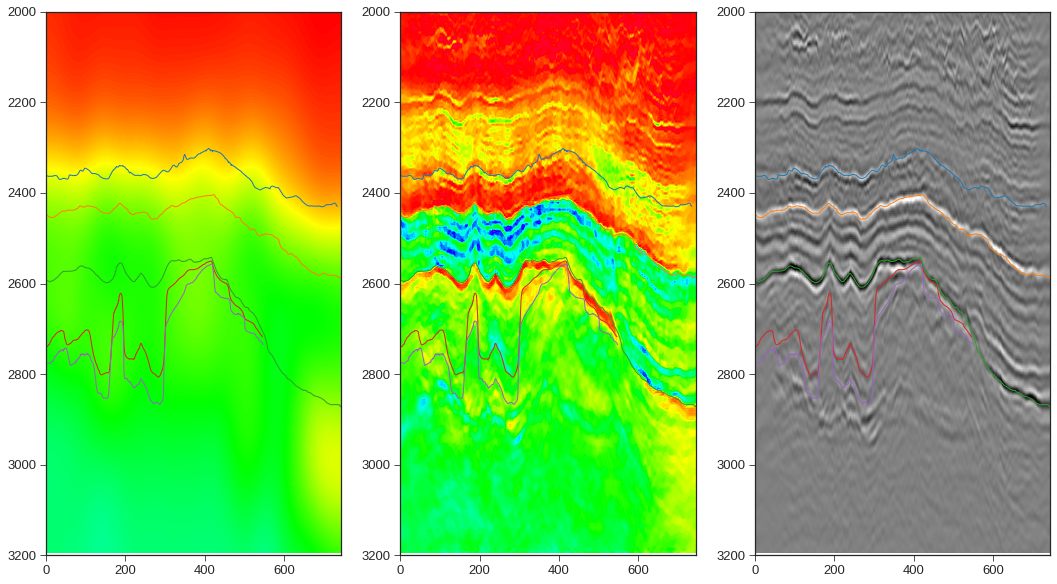

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(np.exp(ai_fence.T), cmap='gist_rainbow', vmin=3000, vmax=20000, 
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[0].plot(x_seis, horizons_fence[horname], lw=1)
axs[0].axis('tight')
axs[0].set_ylim(3200,2000);
axs[1].imshow(np.exp(mpd), cmap='gist_rainbow', vmin=3000, vmax=20000, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[1].plot(x_seis, horizons_fence[horname], lw=1)
axs[1].axis('tight')
axs[1].set_ylim(3200,2000);
axs[2].imshow(seismic_fence.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[2].plot(x_seis, horizons_fence[horname], lw=1)
axs[2].axis('tight')
axs[2].set_ylim(3200,2000);

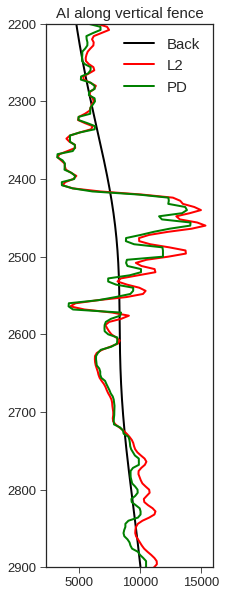

In [20]:
plt.figure(figsize=(3, 10))
plt.plot(np.exp(ai_fence[nfence//2]), t_cut, 'k', lw=2, label='Back')
plt.plot(np.exp(minv[:, nfence//2]), t_cut, 'r', lw=2, label='L2')
plt.plot(np.exp(mpd[:, nfence//2]), t_cut, 'g', lw=2, label='PD')
plt.gca().invert_yaxis()
plt.ylim(2900, 2200)
plt.title('AI along vertical fence')
plt.legend();

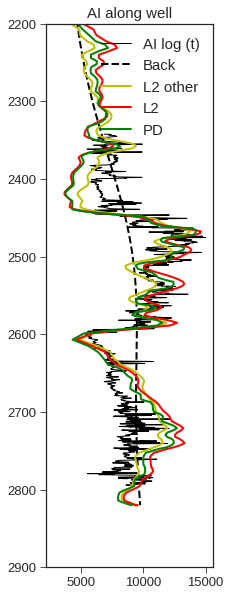

In [21]:
mpd_t = RegularGridInterpolator((x_seis, t_cut), 
                                 np.exp(mpd).T, 
                                 bounds_error=False,
                                 fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

plt.figure(figsize=(3, 10))
plt.plot(filtfilt(np.ones(nsmooth)/nsmooth, 1, well_ai), well_twt, 
         'k', lw=1, label='AI log (t)')
plt.plot(np.exp(ai_fence_t), twell, '--k', lw=2, label='Back')
plt.plot(aiextr1_t_int, twell_int, 'y', lw=2, label='L2 other')
plt.plot(minv_t, twell_int, 'r', lw=2, label='L2')
plt.plot(mpd_t, twell_int, 'g', lw=2, label='PD')
plt.gca().invert_yaxis()
plt.title('AI along well')
plt.ylim(2900, 2200)
plt.legend();

## 2D Post-stack segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [22]:
#cl = np.log(np.array([4000 - 300, 7600 + 200, 10200 - 100, 13000 - 400]))
cl = np.log(np.array([4000 - 50, 7600 + 40, 10200 - 60, 13000 - 30]))
print(cl)
ncl = len(cl)

[8.28147086 8.94115288 9.22424328 9.47039428]


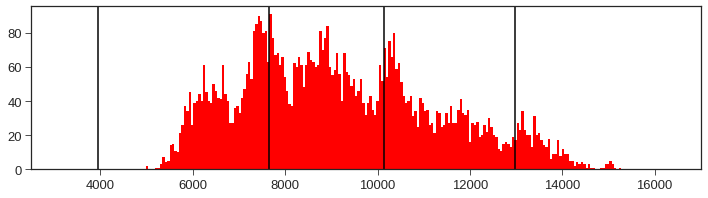

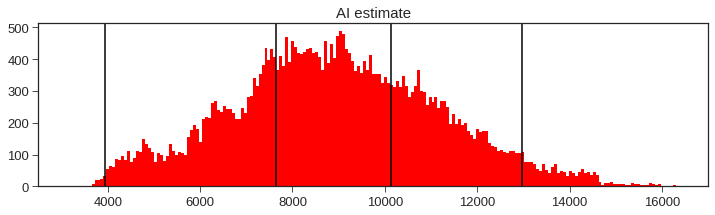

In [23]:
plt.figure(figsize=(12, 3))
plt.hist(well_ai.ravel(), bins=200, color='r');
for c in cl:
    plt.axvline(np.exp(c), c='k')
plt.xlim(2500, 17000)

plt.figure(figsize=(12, 3))
plt.hist(np.exp(mpd[150:200].ravel()), bins=200, color='r');
for c in cl:
    plt.axvline(np.exp(c), c='k')
plt.title('AI estimate')
plt.xlim(2500, 17000);

Poor man's segmentation

In [24]:
cl_nn = np.argmin(np.abs(mpd.ravel()[:, np.newaxis] - cl[:, np.newaxis].T), axis=1)
cl_nn = cl_nn.reshape(mpd.shape)

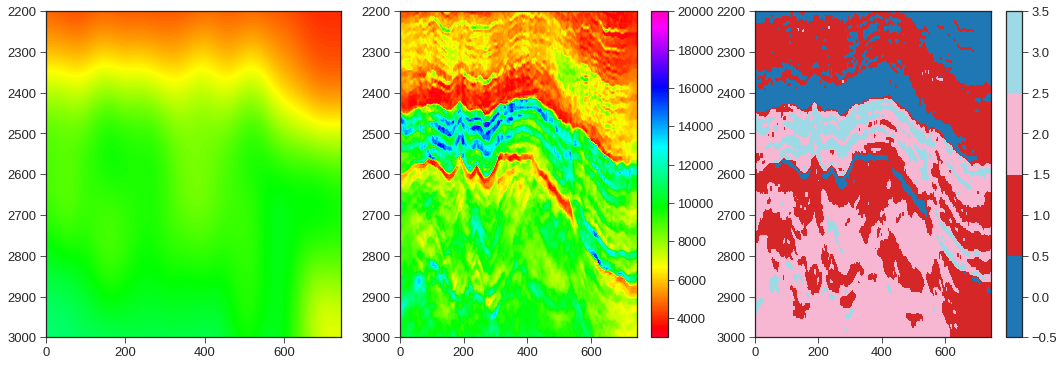

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(np.exp(ai_fence.T), cmap='gist_rainbow', vmin=3000, vmax=20000, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[0].axis('tight')
axs[0].set_ylim(3000,2200);
im = axs[1].imshow(np.exp(mpd), cmap='gist_rainbow', vmin=3000, vmax=20000, interpolation='sinc',
                   extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[1].axis('tight')
axs[1].set_ylim(3000,2200);
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(cl_nn, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[2].axis('tight')
axs[2].set_ylim(3000,2200)
plt.colorbar(im, ax=axs[2]);

Segmentation by inversion

In [ ]:
segpd, segpd_classes = \
    Segment(mpd, cl, 20., .7, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

segpd_high, segpd_classes_high = \
    Segment(mpd, cl, 20., 5., niter=50, show=True, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   9.97705e-01   0.000e+00   1.331e+04   5.388e+04       6.719e+04
     2   9.98650e-01   0.000e+00   1.361e+04   4.407e+04       5.768e+04
     3   1.00018e+00   0.000e+00   1.258e+04   4.229e+04       5.487e+04
     4   1.00128e+00   0.000e+00   1.157e+04   4.207e+04       5.364e+04
     5   1.00179e+00   0.000e+00   1.071e+04   4.224e+04       5.295e+04
     6   1.00164e+00   0.000e+00   1.004e+04   4.247e+04       5.251e+04
     7   1.00119e+00   0.000e+00   9.578e+03   4.268e+04       5.226e+04
     8

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
axs[0].imshow(np.exp(ai_fence.T), cmap='gist_rainbow', vmin=2000, vmax=17000, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[0].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
im = axs[1].imshow(np.exp(mpd), cmap='gist_rainbow', vmin=2000, vmax=17000, interpolation='sinc',
                   extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[1].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(segpd_classes, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[2].axis('tight')
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[2].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200)
plt.colorbar(im, ax=axs[2])
im=axs[3].imshow(segpd_classes_high, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[3].axis('tight')
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[3].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[3].axis('tight')
axs[3].set_ylim(3200,2200)
plt.colorbar(im, ax=axs[3]);

In [ ]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt, nfence), cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd_high[:, icl].reshape(nt, nfence), cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

## 2D Post-stack joint inversion & segmentation

In [ ]:
alpha = 0.05
beta = 1.
delta = 4.

niter = 2
tolstop = 0.

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.2 / np.sqrt(L)
mu = 0.95 / (tau * L)
print(tau*mu*L<1)

mjoint, vjoint, vcljoint, rre, psnr, mjoint_hist, vjoint_hist = \
    joint_inversion_segmentation(seismic_fence.T, ai_fence.T, cl, Lop, alpha, beta, delta, tau, mu,
                                 niter=niter, l2niter=20, pdniter=100,
                                 segmentniter=50, bisectniter=10, tolstop=tolstop,
                                 plotflag=True, show=True)

In [ ]:
mjoint_t = RegularGridInterpolator((x_seis, t_cut), 
                                 np.exp(mjoint.reshape(nt, nfence)).T, 
                                 bounds_error=False,
                                 fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

vcljoint_t = RegularGridInterpolator((x_seis, t_cut), 
                                     vcljoint.reshape(nt, nfence).T, 
                                     bounds_error=False,
                                     fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T)

vjoint_t = np.array([RegularGridInterpolator((x_seis, t_cut),
                                             vjoint[:, icl].reshape(nt, nfence).T, bounds_error=False, 
                                             fill_value=np.nan)(np.vstack((xfence_int, twell_int)).T) for icl in range(ncl)])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Joint inversion')
axs[0].imshow(np.exp(ai_fence.T), cmap='gist_rainbow', vmin=2000, vmax=17000, interpolation='sinc',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[0].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200)
axs[0].set_title('AI back')
im = axs[1].imshow(np.exp(mjoint.reshape(nt, nfence)), 
                   cmap='gist_rainbow', vmin=2000, vmax=17000, interpolation='sinc',
                   extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[1].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200)
axs[1].set_title('AI inv')
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(vcljoint.reshape(nt, nfence), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[2].axis('tight')
for ihor, horname in enumerate(horizons_fence.keys()):
    axs[2].plot(x_seis, horizons_fence[horname], 'k', lw=1)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200)
axs[2].set_title('Segmentation')
plt.colorbar(im, ax=axs[2]);

In [ ]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(vjoint.reshape(nt*nfence, ncl)[:, icl].reshape(nt, nfence), 
                         cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

In [ ]:
def plot_horizon_tracking(hor_list, hor_min_lenght=300, filter='', flip=False):
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    im=ax.imshow(vcljoint.reshape(nt, nfence), cmap=cm.get_cmap('tab20', ncl), 
                 vmin=-0.5, vmax=ncl-0.5, alpha=0.3,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
    for i, h in hor_list.iterrows():   
        if not flip:
            ax.plot(h['x'], h['y'] * dt + t_cut[0], '.', ms=2, c='k')
        else:
            ax.plot(nfence-h['x'], h['y'] * dt + t_cut[0], '.', ms=2, c='k')
    ax.axis('tight')

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.imshow(np.exp(mjoint.reshape(nt, nfence)), cmap='gist_rainbow', 
              vmin=2000, vmax=17000, alpha=0.5,
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
    for i, h in hor_list.iterrows():   
        if not flip:
            ax.plot(h['x'], h['y'] * dt + t_cut[0], '.', ms=2, c='k')
        else:
            ax.plot(nfence-h['x'], h['y'] * dt + t_cut[0], '.', ms=2, c='k')
    ax.axis('tight')

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.imshow(seismic_fence.T, aspect="auto", vmin=-10, vmax=10, cmap='gray',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
    for i, h in hor_list.iterrows():   
        if not flip:
            ax.plot(h['x'], h['y'] * dt + t_cut[0], '.', ms=2, c='k')
        else:
            ax.plot(nfence-h['x'], h['y'] * dt + t_cut[0], '.', ms=2, c='k')
    ax.axis('tight')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    im=ax.imshow(vcljoint.reshape(nt, nfence), cmap=cm.get_cmap('tab20', ncl), 
                 vmin=-0.5, vmax=ncl-0.5, alpha=0.5,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
    for i, h in hor_list.iterrows():   
        if h['chosen'] and  filter in h['hs_id'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:
            if not flip:
                ax.plot(h['regx'], h['regy'] * dt + t_cut[0], lw=3)
            else:
                ax.plot(nfence-h['regx'], h['regy'] * dt + t_cut[0], lw=3)
    ax.axis('tight')

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.imshow(np.exp(mjoint.reshape(nt, nfence)), cmap='gist_rainbow', 
              vmin=2000, vmax=17000, alpha=0.5,
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
    for i, h in hor_list.iterrows():   
        if h['chosen'] and filter in h['hs_id'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:            
            if not flip:
                ax.plot(h['regx'], h['regy'] * dt + t_cut[0], lw=3)
            else:
                ax.plot(nfence-h['regx'], h['regy'] * dt + t_cut[0], lw=3)
    ax.axis('tight')

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    ax.imshow(seismic_fence.T, aspect="auto", vmin=-10, vmax=10, cmap='gray',
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
    for ihor, horname in enumerate(horizons_fence.keys()):
        plt.plot(x_seis, horizons_fence[horname], '--k', lw=2)
    for i, h in hor_list.iterrows():   
        if h['chosen'] and filter in h['hs_id'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:            
            if not flip:
                ax.plot(h['regx'], h['regy'] * dt + t_cut[0], lw=3)
            else:
                ax.plot(nfence-h['regx'], h['regy'] * dt + t_cut[0], lw=3)
    ax.axis('tight')

In [ ]:
horizon_list_joint_above = multiclass_horizons(ncl, vcljoint.reshape(nt, nfence),
                                               tvlowerthresh=0.2,
                                               nn_lim=3, line_minlen=10, 
                                               lb_lenclasscompute=2000, lb_lenclasswindow=3,
                                               lb_idmethod='above',
                                               difflim=10,
                                               verbose=True)

In [ ]:
plot_horizon_tracking(horizon_list_joint_above, hor_min_lenght=20)

## Paper figures

In [ ]:
dtwell_int = twell_int[1] - twell_int[0]

gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=[1, 1, .4])
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[:,2])
plt.tight_layout()

ax1.imshow(np.exp(ai_fence.T), cmap=cmap_ai, vmin=3500, vmax=17000, 
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
    ax1.plot(x_seis, horizons_fence[horname], 'k', lw=1)
ax1.plot(xfence_int, twell_int, 'k')
ax1.set_title('Background', fontsize=20)
ax1.set_ylabel('TWT[s]', fontsize=18)
ax1.axis('tight')
ax1.set_ylim(3000, 2200)
ax1.text(-0.2, 1.1, '(a)', fontsize=15, fontweight='bold', family='serif', transform=ax1.transAxes)

ax2.imshow(np.exp(minv), cmap=cmap_ai, vmin=3500, vmax=17000, 
           extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
#for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
#    ax2.plot(x_seis, horizons_fence[horname], 'k', lw=1)
ax2.plot(xfence_int, twell_int, 'k')
ax2.arrow(640, 2610, -10, 40, width=3, head_width=20, color='w')
ax2.set_title('Least-squares', fontsize=20)
ax2.axis('tight')
ax2.set_ylim(3000, 2200)
ax2.text(-0.2, 1.1, '(b)', fontsize=15, fontweight='bold', family='serif', transform=ax2.transAxes)

ax3.imshow(np.exp(mpd), cmap=cmap_ai, vmin=3500, vmax=17000, 
           extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
#for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
#    ax3.plot(x_seis, horizons_fence[horname], 'k', lw=1)
ax3.plot(xfence_int, twell_int, 'k')
ax3.arrow(640, 2610, -10, 40, width=3, head_width=20, color='w')
ax3.set_title('Primal-Dual', fontsize=20)
ax3.set_xlabel('#Trace', fontsize=18)
ax3.set_ylabel('TWT[s]', fontsize=18)
ax3.axis('tight')
ax3.set_ylim(3000, 2200)
ax3.text(-0.2, 1.1, '(c)', fontsize=15, fontweight='bold', family='serif', transform=ax3.transAxes)

ax4.imshow(np.exp(mjoint.reshape(nt, nfence)), cmap=cmap_ai, vmin=3500, vmax=17000, 
           extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
#for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
#    ax4.plot(x_seis, horizons_fence[horname], 'k', lw=1)
ax4.plot(xfence_int, twell_int, 'k')
ax4.arrow(640, 2610, -10, 40, width=3, head_width=20, color='w')
ax4.set_title('Joint', fontsize=20)
ax4.set_xlabel('#Trace', fontsize=18)
ax4.axis('tight')
ax4.set_ylim(3000, 2200)
ax4.text(-0.2, 1.1, '(d)', fontsize=15, fontweight='bold', family='serif', transform=ax4.transAxes)

nsmooth=20
ax5.plot(filtfilt(np.ones(nsmooth)/nsmooth, 1, well_ai), well_twt, 
         'k', lw=3, label='AI log (t)')
ax5.plot(np.exp(ai_fence_t), twell, '--k', lw=1, label='Back')
ax5.plot(minv_t, twell_int, 'r', lw=2, label='L2')
ax5.plot(mpd_t, twell_int, 'g', lw=2, label='PD')
ax5.plot(mjoint_t, twell_int, 'm', lw=2, label='Joint')
ax5.set_title('Along well', fontsize=20)
ax5.set_ylabel('TWT[s]', fontsize=18)
ax5.set_ylim(2800, 2350)
ax5.legend(bbox_to_anchor=(1.9, 1.), fontsize=16)
ax5.text(0.5, 1.05, '(e)', ha='center', fontsize=15, fontweight='bold', family='serif', transform=ax5.transAxes)

plt.tight_layout()
plt.savefig('Figs/Volve_inv_4clpert.eps', dpi=80, bbox_inches='tight');

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 4))
axs[0].imshow(np.exp(minv), cmap=cmap_ai, vmin=3500, vmax=17000, 
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[0].plot(np.arange(len(twell)), twell, 'k')
axs[0].set_title('Least-Squared', fontsize=18)
axs[0].set_ylabel('TWT[s]')
axs[0].set_xlabel('#Trace')
axs[0].axis('tight')
axs[0].text(0.5, 1.2, '(a)', ha='center',
            fontsize=17, fontweight='bold', family='serif', transform=axs[0].transAxes)

axs[1].imshow(np.exp(mpd), cmap=cmap_ai, vmin=3500, vmax=17000, 
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[1].plot(np.arange(len(twell)), twell, 'k')
axs[1].set_title('Primal-Dual', fontsize=18)
axs[1].set_xlabel('#Trace')
axs[1].axis('tight')
axs[1].text(0.5, 1.2, '(b)', ha='center',
            fontsize=17, fontweight='bold', family='serif', transform=axs[1].transAxes)

axs[2].imshow(np.exp(mjoint.reshape(nt, nfence)), cmap=cmap_ai, vmin=3500, vmax=17000, 
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[2].plot(np.arange(len(twell)), twell, 'k')
axs[2].set_title('Joint', fontsize=18)
axs[2].set_xlabel('#Trace')
axs[2].axis('tight')
axs[2].set_xlim(350, 560);
axs[2].set_ylim(2750, 2500);
axs[2].text(0.5, 1.2, '(c)', ha='center',
            fontsize=17, fontweight='bold', family='serif', transform=axs[2].transAxes)
plt.savefig('Figs/Volve_invzoom_4clpert.eps', dpi=80, bbox_inches='tight');

In [ ]:
cmap_classes = 'tab20'
hor_min_lenght = 520
hor_nsmooth = 10
horinterp = False
horlist = horizon_list_joint_above

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 10),
                        gridspec_kw={'width_ratios': [1, 0.1]})
axs[0, 0].imshow(vcljoint.reshape(nt, nfence), cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[0, 0].plot(xfence_int, twell_int, 'k')
for i, h in horlist.iterrows():   
    if h['chosen'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:
        if not horinterp:
            axs[0, 0].plot(h['regx'], filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                               h['regy'] * dt + t_cut[0]), lw=3, c='w')
        else:
            xfinal = np.arange(h['regx'][~np.isnan(h['regy'])].min(), 
                               h['regx'][~np.isnan(h['regy'])].max())
            horfinal = filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                np.interp(xfinal,
                                          h['regx'][~np.isnan(h['regy'])], 
                                          h['regy'][~np.isnan(h['regy'])] * dt + t_cut[0]))
            axs[0, 0].plot(xfinal, horfinal, lw=3, c='w')
axs[0, 0].axis('tight')
axs[0, 0].set_ylabel('TWT[s]')
axs[0, 0].set_title('Segmentation')
axs[0, 0].set_ylim(3000, 2200)
axs[0, 0].text(-0.1, 1.1, '(a)', fontsize=15, fontweight='bold', family='serif', transform=axs[0, 0].transAxes)

axs[1, 0].imshow(seismic_fence.T, cmap='gray', vmin=-5, vmax=5, 
              extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
axs[1, 0].plot(xfence_int, twell_int, 'k')
axs[1, 0].axis('tight')
for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
    axs[1, 0].plot(x_seis, horizons_fence[horname], 'k', lw=1)

colors = ['r', 'b', 'g', 'y', 'm', 'k']
isel = 0
for i, h in horlist.iterrows():   
    if h['chosen'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:
        print(h['hs_id']+', '+colors[isel])
        if not horinterp:
            axs[1, 0].plot(h['regx'], filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                           h['regy'] * dt + t_cut[0]), lw=3, c=colors[isel])
        else:
            xfinal = np.arange(h['regx'][~np.isnan(h['regy'])].min(), 
                               h['regx'][~np.isnan(h['regy'])].max())
            horfinal = filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                np.interp(xfinal,
                                          h['regx'][~np.isnan(h['regy'])], 
                                          h['regy'][~np.isnan(h['regy'])] * dt + t_cut[0]))
            axs[1, 0].plot(xfinal, horfinal, lw=3, c=colors[isel])
        isel += 1
        
axs[1, 0].set_xlabel(r'$x [m]$')
axs[1, 0].set_title('Detected Horizons')
axs[1, 0].set_xlabel('#Trace')
axs[1, 0].set_ylabel('TWT[s]')
axs[1, 0].set_ylim(3000, 2200)
axs[1, 0].text(-0.1, 1.1, '(c)', fontsize=15, fontweight='bold', family='serif', transform=axs[1, 0].transAxes)

norm = Normalize(vmin=0, vmax=ncl)
probs = vjoint_t.T
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((vjoint_t.shape[1], 1)), cdf))
for icl in range(ncl):
    axs[0, 1].fill_betweenx(twell_int, cdf[:, icl], cdf[:, icl+1], 
                            color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_title('Probs.')
axs[0, 1].text(0.5, 1.1, '(b)', ha='center',
               fontsize=15, fontweight='bold', family='serif', transform=axs[0, 1].transAxes)

axs[1, 1].axis('off')
plt.tight_layout()
plt.savefig('Figs/Volve_seg_4clpert.eps', dpi=80, bbox_inches='tight');

In [ ]:
cmap_classes = 'tab20'

fig, ax = plt.subplots(1, 1,figsize=(7, 5))
ax.imshow(cl_nn, cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
          extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
ax.plot(xfence_int, twell_int, 'k')
ax.axis('tight')
ax.set_ylabel('TWT[s]')
ax.set_title('Point-wise Segmentation (4 classes)')
ax.set_ylim(3000, 2200)
ax.text(-0.1, 1.1, '(b)', fontsize=15, fontweight='bold', family='serif', transform=ax.transAxes)

plt.savefig('Figs/Volve_segnotv_4clpert.eps', dpi=80, bbox_inches='tight');

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(7, 5))
ax.imshow(vcljoint.reshape(nt, nfence), cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
          extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
ax.plot(xfence_int, twell_int, 'k')
ax.axis('tight')
ax.set_ylabel('TWT[s]')
ax.set_title('Segmentation (4 classes)')
ax.set_ylim(3000, 2200)
ax.text(-0.1, 1.1, '(e)', fontsize=15, fontweight='bold', family='serif', transform=ax.transAxes)
for i, h in horlist.iterrows():   
    if h['chosen'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:
        if not horinterp:
            ax.plot(h['regx'], filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                               h['regy'] * dt + t_cut[0]), lw=3, c='w')
        else:
            xfinal = np.arange(h['regx'][~np.isnan(h['regy'])].min(), 
                               h['regx'][~np.isnan(h['regy'])].max())
            horfinal = filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                np.interp(xfinal,
                                          h['regx'][~np.isnan(h['regy'])], 
                                          h['regy'][~np.isnan(h['regy'])] * dt + t_cut[0]))
            ax.plot(xfinal, horfinal, lw=3, c='w')

plt.savefig('Figs/Volve_seg_4clpert.eps', dpi=80, bbox_inches='tight');

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(13, 10))
axs[0, 0].imshow(seismic_fence.T, cmap='gray', vmin=-5, vmax=5, 
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
    axs[0, 0].plot(x_seis, horizons_fence[horname], 'k', lw=2)
axs[0, 0].set_ylabel('TWT[s]')
axs[0, 0].axis('tight')
axs[0, 0].text(0.5, 1.05, '(a)', ha='center', fontsize=18, fontweight='bold', family='serif', transform=axs[0, 0].transAxes)

axs[1, 0].imshow(seismic_fence.T, cmap='gray', vmin=-5, vmax=5, 
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
colors = ['r', 'b', 'g', 'y', 'm', 'k']
isel = 0
for i, h in horlist.iterrows():   
    if h['chosen'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:
        if not horinterp:
            axs[1, 0].plot(h['regx'], filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                           h['regy'] * dt + t_cut[0]), lw=3, c=colors[isel])
        else:
            xfinal = np.arange(h['regx'][~np.isnan(h['regy'])].min(), 
                               h['regx'][~np.isnan(h['regy'])].max())
            horfinal = filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                np.interp(xfinal,
                                          h['regx'][~np.isnan(h['regy'])], 
                                          h['regy'][~np.isnan(h['regy'])] * dt + t_cut[0]))
            axs[1, 0].plot(xfinal, horfinal, lw=3, c=colors[isel])
        isel += 1
axs[1, 0].set_ylabel('TWT[s]')
axs[1, 0].set_xlabel('#Trace')
axs[1, 0].axis('tight')
axs[1, 0].text(0.5, 1.05, '(c)', ha='center', fontsize=18, fontweight='bold', family='serif', transform=axs[1, 0].transAxes)

axs[0, 1].imshow(np.exp(mjoint.reshape(nt, nfence)), cmap=cmap_ai, vmin=3500, vmax=17000, alpha=0.8,
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(list(horizons_fence.keys())[:-2]):
    axs[0, 1].plot(x_seis, horizons_fence[horname], 'k', lw=2)
axs[0, 1].axis('tight')
axs[0, 1].text(0.5, 1.05, '(b)', ha='center', fontsize=18, fontweight='bold', family='serif', transform=axs[0, 1].transAxes)


axs[1, 1].imshow(np.exp(mjoint.reshape(nt, nfence)), cmap=cmap_ai, vmin=3500, vmax=17000, alpha=0.8, 
                 extent=(x_seis[0], x_seis[-1], t_cut[-1], t_cut[0]))
colors = ['r', 'b', 'g', 'y', 'm', 'k']
isel = 0
for i, h in horlist.iterrows():   
    if h['chosen'] and len(h['regy'][~np.isnan(h['regy'])]) > hor_min_lenght:
        if not horinterp:
            axs[1, 1].plot(h['regx'], filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                           h['regy'] * dt + t_cut[0]), lw=3, c=colors[isel])
        else:
            xfinal = np.arange(h['regx'][~np.isnan(h['regy'])].min(), 
                               h['regx'][~np.isnan(h['regy'])].max())
            horfinal = filtfilt(np.ones(hor_nsmooth)/hor_nsmooth, 1, 
                                np.interp(xfinal,
                                          h['regx'][~np.isnan(h['regy'])], 
                                          h['regy'][~np.isnan(h['regy'])] * dt + t_cut[0]))
            axs[1, 1].plot(xfinal, horfinal, lw=3, c=colors[isel])
        isel += 1
axs[1, 1].axis('tight')
axs[1, 1].set_xlabel('#Trace')
axs[1, 1].set_xlim(200, 740)
axs[1, 1].set_ylim(2600, 2150)
axs[1, 1].text(0.5, 1.05, '(d)', ha='center', fontsize=18, fontweight='bold', family='serif', transform=axs[1, 1].transAxes)
plt.tight_layout()
plt.savefig('Figs/Volve_segzoom_4clpert.eps', dpi=60, bbox_inches='tight');